In [1]:
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# LOAD AND PREPARE DATASET

In [3]:
mnist = fetch_openml('mnist_784', cache=False)

In [4]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [5]:
# Normalization of the pixel values
X /= 255.0
X = X.reshape(-1, 1, 28, 28)
X.shape

(70000, 1, 28, 28)

In [6]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [7]:
# Shape of the data
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (56000, 1, 28, 28)
X_test shape:  (14000, 1, 28, 28)
y_train shape:  (56000,)
y_test shape:  (14000,)


# DEFINE MODEL

In [8]:
class Model(nn.Module): 
    
    def __init__(self, dropout=0.5, conv_l1=16, conv_l2=32, conv_l3=64, fc1=256): 

        super().__init__()

        self.conv_l1 = nn.Conv2d(1, conv_l1, kernel_size=5)
        self.conv_l2 = nn.Conv2d(conv_l1, conv_l2, kernel_size=3)
        self.conv_l3 = nn.Conv2d(conv_l2, conv_l3, kernel_size=5)
        self.conv_l3_drop = nn.Dropout2d(p=dropout)

        self.fc1 = nn.Linear(conv_l3*7*7, fc1) 
        self.fc2 = nn.Linear(fc1, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self,x): 
        x = torch.relu(self.conv_l1(x))
        x = torch.relu(F.max_pool2d(self.conv_l2(x), 2))
        x = torch.relu(self.conv_l3_drop(self.conv_l3(x)))
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

# Tune Parameters

In [9]:
!pip install skorch

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Loss function
loss_function = nn.CrossEntropyLoss()

#Early Stopping
from skorch.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=25,
    # threshold=0.001,
    # threshold_mode='rel',
    lower_is_better=True)

#Model initialization
from skorch import NeuralNetClassifier

net = NeuralNetClassifier(
    module=Model,
    module__conv_l1=16,
    module__conv_l2=32,
    module__conv_l3=64,
    module__fc1=256,
    max_epochs=100,
    device=device,
    optimizer = optim.Adam,
    optimizer__lr=0.0001,
    optimizer__weight_decay=1e-5,
    criterion=nn.CrossEntropyLoss,
    callbacks = [early_stopping],
)

Training device: cuda


In [11]:
from sklearn.model_selection import GridSearchCV

# Convolution Neural Network
params = {
    'module__conv_l1': [16],
    'module__conv_l2': [32, 48],
    'module__conv_l3': [48, 64],
    'max_epochs': [100],
    'optimizer__lr':[0.001, 0.0001],
    'optimizer__weight_decay':[1e-4,1e-5] #L2 norm
}

gs = GridSearchCV(net, params, refit=True, cv=3, scoring="neg_mean_squared_error",verbose=10)

gs.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] max_epochs=100, module__conv_l1=16, module__conv_l2=32, module__conv_l3=48, optimizer__lr=0.001, optimizer__weight_decay=0.0001 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7960       0.8788        1.5826  1.4366
      2        1.5519       0.9606        1.5013  1.3599
      3        1.5214       0.9630        1.4993  1.3544
      4        1.5103       0.9712        1.4899  1.3548
      5        1.5051       0.9751        1.4864  1.3566
      6        1.5038       0.9791        1.4825  1.3429
      7        1.4969       0.9788        1.4824  1.3481
      8        1.4960       0.9800        1.4817  1.3509
      9        1.4940       0.9780        1.4830  1.3382
     10        1.4909       0.9807        1.4797  1.3468
     11        1.4923       0.9825        1.4790  1.3677
     12        1.4900       0.9834        1.4784  1.3465
     13        1.4894       0.9846        1.4762  1.3528
     14        1.4891       0.9839        1.4776  1.3551
     15        1.4888       0.9850        1.4764  1.3567
     16        1.4873       0.9

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.8246       0.8329        1.6286  1.3832
      2        1.6301       0.8598        1.6020  1.3811
      3        1.5783       0.9596        1.5016  1.3714
      4        1.5142       0.9673        1.4937  1.3797
      5        1.5042       0.9752        1.4860  1.3778
      6        1.5009       0.9750        1.4871  1.3757
      7        1.4996       0.9750        1.4862  1.3794
      8        1.4959       0.9792        1.4825  1.3893
      9        1.4929       0.9759        1.4853  1.3810
     10        1.4928       0.9772        1.4839  1.3778
     11        1.4931       0.9833        1.4782  1.3845
     12        1.4906       0.9827        1.4786  1.3815
     13        1.4874       0.9800        1.4811  1.3781
     14        1.4886       0.9831        1.4781  1.3796
     15        1.4892       0.9846        1.4765  1.3859
     16        1.4880       0.9

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.5min remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7997       0.8333        1.6291  1.3816
      2        1.6338       0.8562        1.6046  1.3927
      3        1.6134       0.8631        1.5985  1.3845
      4        1.5479       0.9645        1.4966  1.3824
      5        1.5106       0.9716        1.4897  1.3943
      6        1.5019       0.9748        1.4871  1.3954
      7        1.4987       0.9751        1.4861  1.3853
      8        1.4973       0.9760        1.4852  1.3935
      9        1.4939       0.9811        1.4811  1.3878
     10        1.4918       0.9806        1.4814  1.3913
     11        1.4922       0.9802        1.4810  1.3957
     12        1.4907       0.9787        1.4825  1.3876
     13        1.4878       0.9825        1.4791  1.3981
     14        1.4875       0.9823        1.4790  1.3963
     15        1.4870       0.9834        1.4776  1.3927
     16        1.4864       0.9

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.7min remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.8698       0.6724        1.7864  1.3852
      2        1.6955       0.8606        1.6005  1.3851
      3        1.6127       0.8732        1.5877  1.3829
      4        1.5290       0.9747        1.4870  1.3827
      5        1.5062       0.9748        1.4867  1.3984
      6        1.5009       0.9772        1.4840  1.3935
      7        1.4988       0.9791        1.4823  1.3880
      8        1.4967       0.9804        1.4807  1.3821
      9        1.4933       0.9813        1.4799  1.3864
     10        1.4921       0.9808        1.4796  1.4123
     11        1.4898       0.9839        1.4776  1.4034
     12        1.4879       0.9830        1.4782  1.3913
     13        1.4877       0.9833        1.4777  1.4469
     14        1.4861       0.9847        1.4765  1.3984
     15        1.4865       0.9843        1.4768  1.3848
     16        1.4843       0.9

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  8.0min remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.8200       0.7611        1.6990  1.4381
      2        1.6851       0.8503        1.6104  1.3999
      3        1.5536       0.9559        1.5058  1.3878
      4        1.5179       0.9676        1.4928  1.3970
      5        1.5052       0.9715        1.4898  1.3831
      6        1.5014       0.9687        1.4918  1.4000
      7        1.4975       0.9771        1.4839  1.3796
      8        1.4953       0.9782        1.4826  1.3843
      9        1.4940       0.9794        1.4819  1.3961
     10        1.4915       0.9787        1.4824  1.3927
     11        1.4915       0.9813        1.4801  1.4302
     12        1.4891       0.9822        1.4791  1.3838
     13        1.4889       0.9835        1.4776  1.3835
     14        1.4871       0.9827        1.4784  1.3834
     15        1.4873       0.9822        1.4787  1.3992
     16        1.4864       0.9

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 10.1min remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.8313       0.8410        1.6207  1.4024
      2        1.6279       0.8619        1.5984  1.3928
      3        1.5351       0.9648        1.4972  1.3903
      4        1.5090       0.9708        1.4911  1.3867
      5        1.5002       0.9763        1.4857  1.3891
      6        1.4958       0.9779        1.4832  1.3928
      7        1.4945       0.9803        1.4812  1.3914
      8        1.4918       0.9791        1.4820  1.3955
      9        1.4902       0.9779        1.4831  1.3925
     10        1.4884       0.9814        1.4800  1.3884
     11        1.4881       0.9823        1.4786  1.3923
     12        1.4890       0.9833        1.4779  1.3868
     13        1.4883       0.9818        1.4796  1.3841
     14        1.4858       0.9838        1.4771  1.3828
     15        1.4853       0.9826        1.4785  1.3955
     16        1.4848       0.9

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 12.0min remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9140       0.8700        1.6063  1.3940
      2        1.6202       0.8990        1.5683  1.4261
      3        1.5877       0.9148        1.5513  1.4173
      4        1.5683       0.9254        1.5393  1.3883
      5        1.5534       0.9316        1.5324  1.4170
      6        1.5435       0.9413        1.5219  1.3974
      7        1.5359       0.9479        1.5154  1.4008
      8        1.5298       0.9506        1.5111  1.3869
      9        1.5232       0.9574        1.5057  1.3917
     10        1.5186       0.9608        1.5023  1.4444
     11        1.5150       0.9613        1.5010  1.3878
     12        1.5116       0.9668        1.4958  1.3904
     13        1.5086       0.9669        1.4953  1.3832
     14        1.5077       0.9696        1.4928  1.3997
     15        1.5049       0.9696        1.4927  1.4027
     16        1.5032       0.9

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 14.3min remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9383       0.8488        1.6315  1.3942
      2        1.6263       0.8927        1.5742  1.3831
      3        1.5854       0.9113        1.5530  1.3965
      4        1.5684       0.9242        1.5413  1.3914
      5        1.5545       0.9294        1.5346  1.3982
      6        1.5452       0.9389        1.5246  1.4067
      7        1.5378       0.9452        1.5186  1.4067
      8        1.5321       0.9510        1.5126  1.3974
      9        1.5248       0.9537        1.5099  1.4247
     10        1.5212       0.9550        1.5077  1.3898
     11        1.5182       0.9574        1.5040  1.3835
     12        1.5162       0.9620        1.5009  1.3912
     13        1.5133       0.9608        1.5010  1.3853
     14        1.5106       0.9654        1.4975  1.3886
     15        1.5079       0.9667        1.4962  1.3999
     16        1.5068       0.9

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 16.7min remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9103       0.8001        1.6708  1.3968
      2        1.6761       0.8224        1.6409  1.3904
      3        1.6539       0.8334        1.6296  1.3895
      4        1.6407       0.8455        1.6180  1.3943
      5        1.6306       0.8519        1.6109  1.4022
      6        1.6208       0.8579        1.6046  1.3941
      7        1.5585       0.9420        1.5233  1.3969
      8        1.5367       0.9490        1.5145  1.3970
      9        1.5284       0.9522        1.5112  1.3895
     10        1.5216       0.9547        1.5076  1.3948
     11        1.5162       0.9604        1.5029  1.3919
     12        1.5120       0.9654        1.4979  1.4171
     13        1.5099       0.9667        1.4965  1.4386
     14        1.5059       0.9683        1.4942  1.3915
     15        1.5040       0.9697        1.4940  1.3947
     16        1.5012       0.9

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 19.1min remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9177       0.8548        1.6252  1.3927
      2        1.6267       0.8930        1.5737  1.3836
      3        1.5904       0.9092        1.5549  1.3851
      4        1.5714       0.9223        1.5425  1.4126
      5        1.5564       0.9341        1.5308  1.4064
      6        1.5448       0.9419        1.5229  1.3850
      7        1.5367       0.9475        1.5163  1.3928
      8        1.5295       0.9531        1.5103  1.3858
      9        1.5251       0.9596        1.5045  1.3968
     10        1.5193       0.9617        1.5009  1.3934
     11        1.5164       0.9661        1.4982  1.3953
     12        1.5120       0.9665        1.4964  1.3831
     13        1.5096       0.9671        1.4952  1.3897
     14        1.5060       0.9703        1.4922  1.3890
     15        1.5030       0.9705        1.4917  1.3873
     16        1.5031       0.9

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 110.5min finished


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7339       0.8549        1.6068  2.4376
      2        1.5840       0.9622        1.4991  2.4364
      3        1.5127       0.9725        1.4886  2.4520
      4        1.5046       0.9730        1.4877  2.4511
      5        1.4983       0.9787        1.4821  2.4405
      6        1.4967       0.9799        1.4810  2.4414
      7        1.4942       0.9831        1.4782  2.4281
      8        1.4903       0.9837        1.4779  2.4377
      9        1.4903       0.9830        1.4781  2.4299
     10        1.4886       0.9833        1.4778  2.4527
     11        1.4886       0.9846        1.4768  2.4416
     12        1.4882       0.9812        1.4800  2.4439
     13        1.4868       0.9848        1.4763  2.4340
     14        1.4864       0.9838        1.4774  2.4277
     15        1.4857       0.9853        1.4762  2.4475
     16        1.4849       0.9

GridSearchCV(cv=3, error_score=nan,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.Model'>,
  module__conv_l1=16,
  module__conv_l2=32,
  module__conv_l3=64,
  module__fc1=256,
),
             iid='deprecated', n_jobs=None,
             param_grid={'max_epochs': [100], 'module__conv_l1': [16],
                         'module__conv_l2': [32, 48],
                         'module__conv_l3': [48, 64],
                         'optimizer__lr': [0.001, 0.0001],
                         'optimizer__weight_decay': [0.0001, 1e-05]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=10)

In [12]:
# Best parameters that are found
print(gs.best_score_, gs.best_params_)

net=gs.best_estimator_

-0.1822859691896832 {'max_epochs': 100, 'module__conv_l1': 16, 'module__conv_l2': 48, 'module__conv_l3': 48, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.0001}


In [13]:
# Train the network with best parameters
net.fit(X_train, y_train)

Re-initializing module because the following parameters were re-set: conv_l1, conv_l2, conv_l3, fc1.
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7845       0.8496        1.6108  2.4803
      2        1.6031       0.9603        1.5012  2.3770
      3        1.5144       0.9728        1.4886  2.3798
      4        1.5049       0.9773        1.4844  2.3832
      5        1.4998       0.9791        1.4823  2.3851
      6        1.4939       0.9771        1.4841  2.3849
      7        1.4933       0.9839        1.4776  2.4110
      8        1.4926       0.9839        1.4772  2.4176
      9        1.4906       0.9849        1.4762  2.4100
     10        1.4890       0.9851        1.4760  2.3958
     11        1.4881       0.9839        1.4768  2.3820
     12        1.4893       0.9844        1.4767  2.3844
     13    

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Model(
    (conv_l1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (conv_l2): Conv2d(16, 48, kernel_size=(3, 3), stride=(1, 1))
    (conv_l3): Conv2d(48, 48, kernel_size=(5, 5), stride=(1, 1))
    (conv_l3_drop): Dropout2d(p=0.5, inplace=False)
    (fc1): Linear(in_features=2352, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=10, bias=True)
    (fc1_drop): Dropout(p=0.5, inplace=False)
  ),
)

# Plot Model Loss

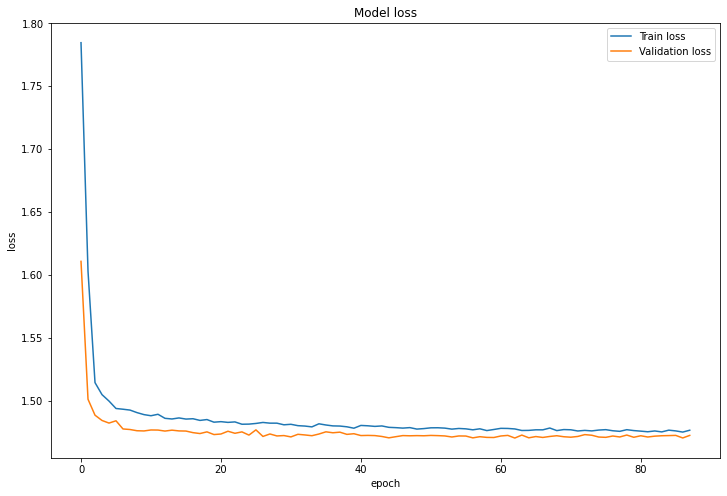

In [14]:
# Gather Train Losses from all epochs
results = net.history
train_loss_log=results[:, 'train_loss']
val_loss_log=results[:, 'valid_loss']

# Plot Train and Validation Loss
plt.figure(figsize=(12,8))
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plt.show()

In [18]:
from sklearn.metrics import accuracy_score

# Prediction and Predicted Classes
y_pred = net.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=0)
print("y_pred :", y_pred)
print("y_pred_classes: ", y_pred_classes)

# Test Accuracy
test_acc = accuracy_score(y_test, y_pred)
print("test_acc: ", test_acc)

y_pred : [8 4 8 ... 2 7 1]
y_pred_classes:  11
test_acc:  0.9882142857142857


In [44]:
# Show All Losses
val_acc=results[:, 'valid_acc'][-1]
val_loss=results[:, 'valid_loss'][-1]
train_loss=results[:, 'train_loss'][-1]

print("Train Loss:\t",round(train_loss,3))
print("Val Accuracy:\t",round(val_acc,3))
print("Test Accuracy:\t",round(float(test_acc),3))

Train Loss:	 1.477
Val Accuracy:	 0.989
Test Accuracy:	 0.988


# Confusion Matrix

In [26]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1339    0    0    0    0    0    3    1    0    0]
 [   0 1596    2    0    0    0    0    1    1    0]
 [   0    8 1356    0    5    0    3    3    3    2]
 [   0    2   10 1407    0    6    0    4    0    4]
 [   0    0    0    0 1288    0    0    2    0    5]
 [   0    1    1    3    0 1257   10    0    1    0]
 [   0    0    0    0    3    1 1392    0    0    0]
 [   0    6    9    0    7    0    0 1477    0    4]
 [   1    6    6    0    3    4    4    2 1318   13]
 [   2    1    0    0    7    2    0    2    1 1405]]


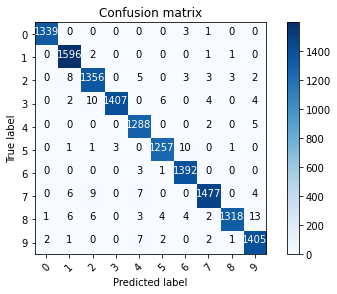

In [27]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
categories=[0,1,2,3,4,5,6,7,8,9]
plot_confusion_matrix(cm,categories)

In [29]:
#Access network parameters
best_network = net.module_

# Conv 1 layer
c1_w = best_network.conv_l1.weight.data.cpu().numpy()
c1_b = best_network.conv_l1.bias.data.cpu().numpy()

# Conv 2 layer
c2_w = best_network.conv_l2.weight.data.cpu().numpy()
c2_b = best_network.conv_l2.bias.data.cpu().numpy()

#First hidden Layer
h1_w = best_network.fc1.weight.data.cpu().numpy()
h1_b = best_network.fc1.bias.data.cpu().numpy()

#Second hidden Layer
h2_w = best_network.fc2.weight.data.cpu().numpy()
h2_b = best_network.fc2.bias.data.cpu().numpy()

# Weight Histograms

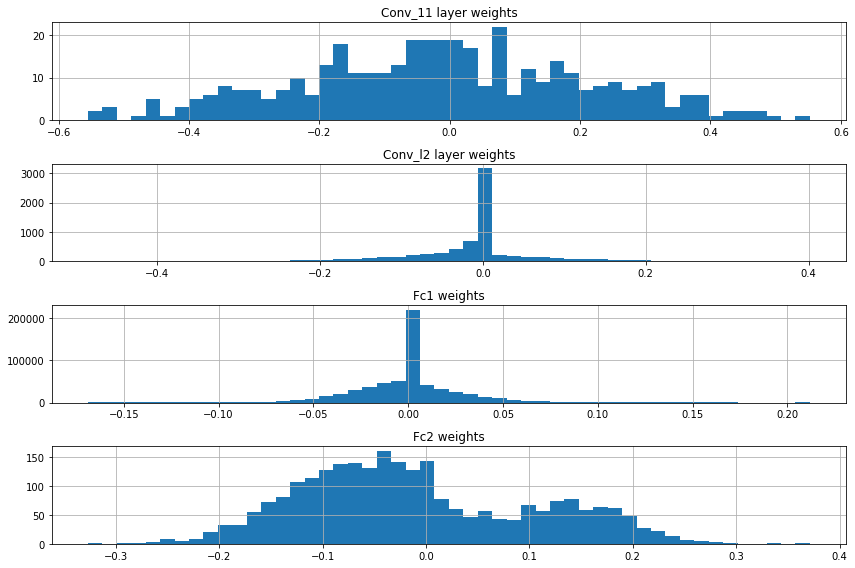

In [30]:
fig, axs = plt.subplots(4, 1, figsize=(12,8))
axs[0].hist(c1_w.flatten(), 50)
axs[0].set_title('Conv_11 layer weights')
axs[1].hist(c2_w.flatten(), 50)
axs[1].set_title('Conv_l2 layer weights')
axs[2].hist(h1_w.flatten(), 50)
axs[2].set_title('Fc1 weights')
axs[3].hist(h2_w.flatten(), 50)
axs[3].set_title('Fc2 weights')

[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

# Activations

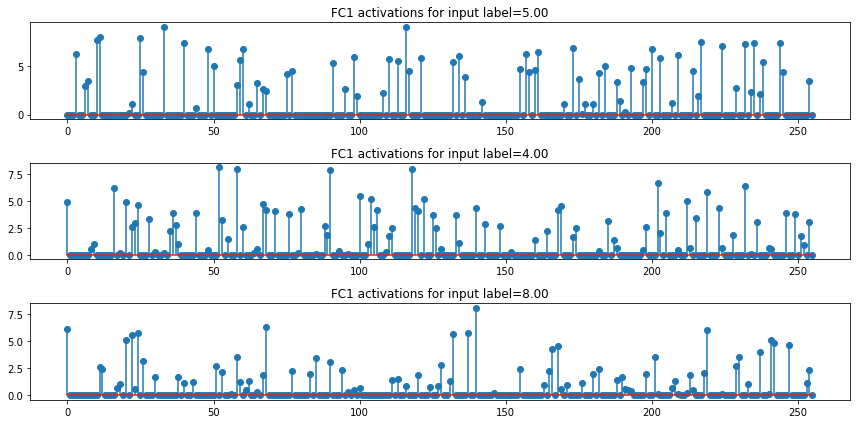

In [31]:
def get_activation(layer, input, output):
    global activation
    #activation = torch.softmax(output)
    activation = torch.relu(output)
    
# Register hook
net=best_network
hook_handle = net.fc1.register_forward_hook(get_activation)


# Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor(X_train[0]).unsqueeze(0).to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor(X_train[1]).unsqueeze(0).to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor(X_train[2]).unsqueeze(0).to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy()[0], use_line_collection=True)
axs[0].set_title('FC1 activations for input label=%.2f' % y_train[0])
axs[1].stem(z2.cpu().numpy()[0], use_line_collection=True)
axs[1].set_title('FC1 activations for input label=%.2f' % y_train[1])
axs[2].stem(z3.cpu().numpy()[0], use_line_collection=True)
axs[2].set_title('FC1 activations for input label=%.2f' % y_train[2])
plt.tight_layout()
plt.show()

# Test Classifications

In [42]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

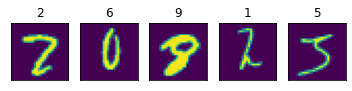

In [43]:
error_mask = y_pred != y_test
plot_example(X_test[error_mask], y_pred[error_mask])